In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
from connector import getConnection

### Interest income distribution

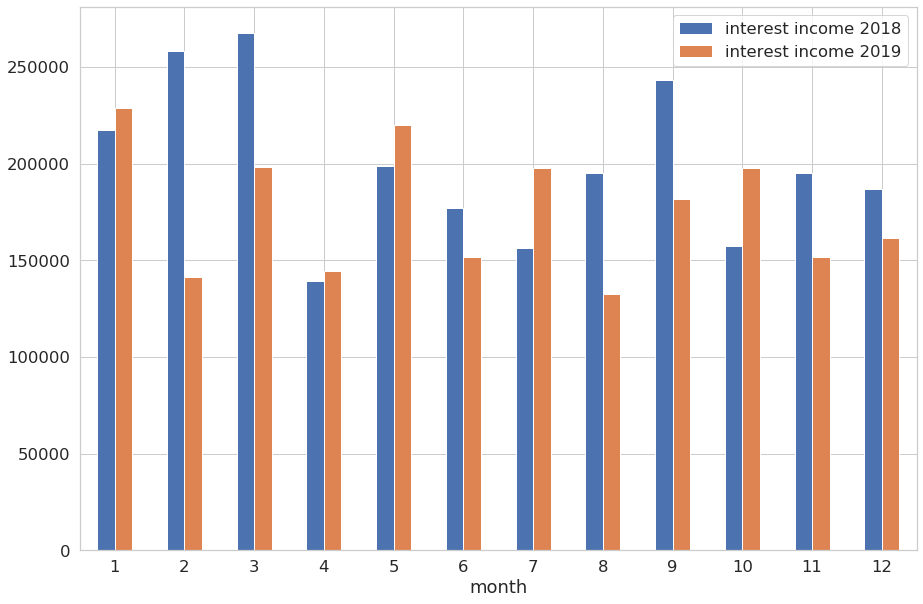

In [57]:
conn = getConnection()

sql = """WITH interest_income_query AS(SELECT  i.sale_date_key, SUM(i.interest) AS interest_income
FROM installment i
GROUP BY i.sale_date_key) 
SELECT iq_2018.month, ROUND(iq_2018.ii::numeric,2) as "interest income 2018",
ROUND(iq_2019.ii::numeric,2) as "interest income 2019"
FROM  
(SELECT d.month, SUM(q.interest_income) AS ii 
FROM public."date" d, interest_income_query q
WHERE d.date_key = q.sale_date_key AND d.year = 2018 
group by d.month) AS iq_2018, 
(SELECT d.month, SUM(q.interest_income) AS ii 
FROM public."date" d, interest_income_query q
WHERE d.date_key = q.sale_date_key AND d.year = 2019 
GROUP BY d.month) AS iq_2019 
WHERE iq_2018.month = iq_2019.month 
ORDER BY iq_2019.month """

df = sqlio.read_sql_query(sql, conn)
df.head()
conn.close()
df.plot(x="month", y=["interest income 2018", "interest income 2019"], kind="bar",figsize=(15,10), rot = 0)


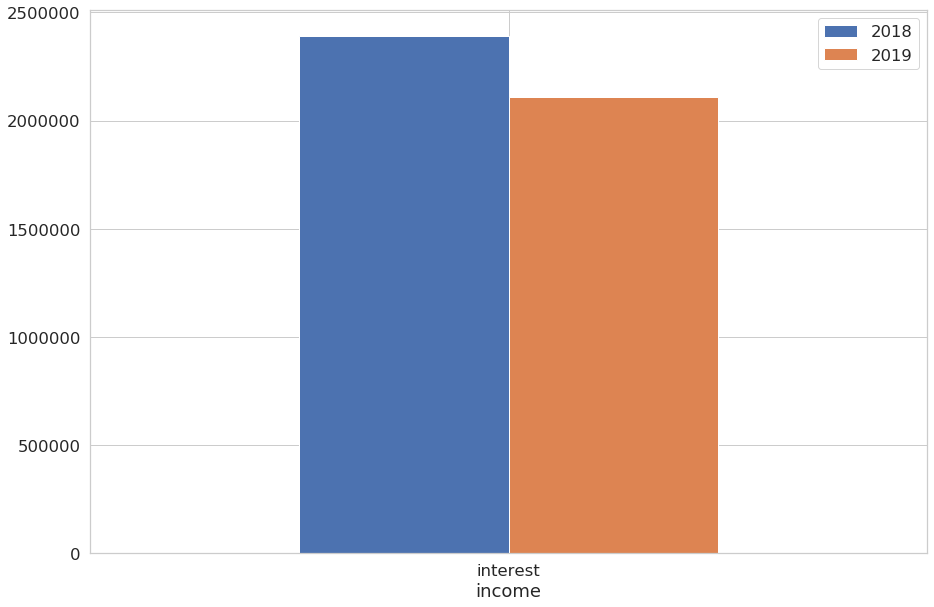

In [58]:
conn = getConnection()

sql = """WITH interest_income_query AS(SELECT  i.sale_date_key, SUM(i.interest) AS interest_income
FROM installment i
GROUP BY i.sale_date_key) 
SELECT 'interest' as income ,ROUND(iq_2018.fees::numeric,2) as "2018",  ROUND(iq_2019.fees::numeric,2) as "2019"
FROM  
(SELECT d.year, SUM(q.interest_income) AS ii 
FROM public."date" d, interest_income_query q
WHERE d.date_key = q.sale_date_key AND d.year = 2018 
group by d.year) AS iq_2018, 
(SELECT d.year, SUM(q.interest_income) AS iii 
FROM public."date" d, interest_income_query q
WHERE d.date_key = q.sale_date_key AND d.year = 2019 
GROUP BY d.year) AS iq_2019 
 """

df = sqlio.read_sql_query(sql, conn)
df = df.set_index('income')
conn.close()
df.head()
df.plot(y=["2018", "2019"], kind="bar",figsize=(15,10), rot = 0)


### Best selling month

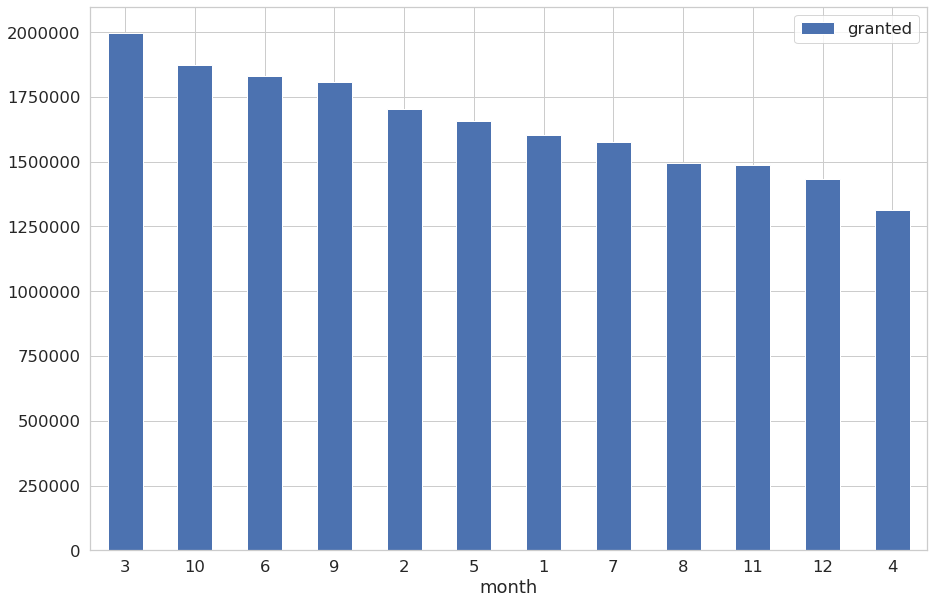

In [41]:
conn = getConnection()

sql = """SELECT d.month, SUM(s.loan_amount) as granted ,  
       RANK() OVER ( ORDER BY SUM(s.loan_amount) DESC ) best 
FROM sale s, public."date" d   
WHERE s.sale_date_key = d.date_key AND d.year = 2018 
GROUP BY  d.month; """

df = sqlio.read_sql_query(sql, conn)
df = df.set_index('month')
conn.close()
df.head()

df.plot.bar(y=['granted'],figsize=(15,10), rot = 0)

### Best 7 days period for sales

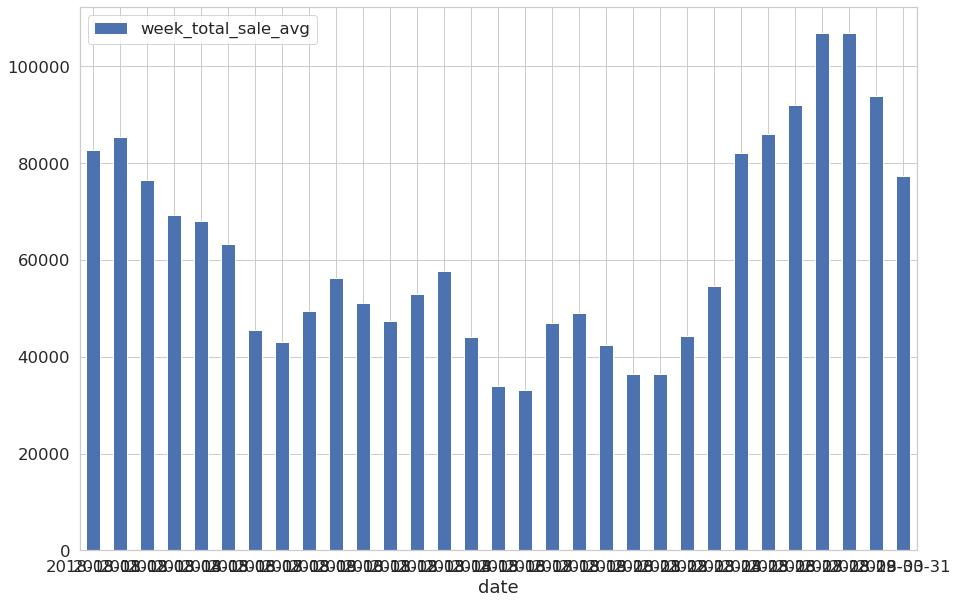

In [50]:
 
conn = getConnection()

sql = """SELECT date, total_granted, week_total_sale_avg 
FROM  
(SELECT q1.date AS date,q1.day as day, q1.month AS month,  SUM(q1.loan_amount) AS total_granted, AVG(SUM(q1.loan_amount)) 
OVER ( ORDER BY q1.date_key ROWS BETWEEN 3 PRECEDING and 3 FOLLOWING ) AS week_total_sale_avg 
FROM  
(   
SELECT d.*, COALESCE(s.loan_amount ,0) AS loan_amount 
FROM 
public."date" d LEFT OUTER JOIN sale s 
ON d.date_key = s.sale_date_key 
WHERE d.year = 2018 AND 
    d.month in (2,3,4) 
)AS q1  
GROUP BY q1.date_key,q1.date, q1.month 
) AS iq 
WHERE iq.month = 3 """

df = sqlio.read_sql_query(sql, conn)
df = df.set_index('date')
conn.close()
df.head()
#df.plot(y=["2018", "2019"], kind="bar",figsize=(15,10), rot = 0)

df.plot.bar(y=['week_total_sale_avg'],figsize=(15,10), rot = 0)
 

